In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats

from sklearn import tree
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier   
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_auc_score
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.inspection import permutation_importance
import pickle
import shap
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm
from sklearn.impute import SimpleImputer


def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(accuracy, precision, recall, f1score)
    return (accuracy, precision, recall, f1score)

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def sort_feature(feature_names, feature_vals):
    assert len(feature_names) == len(feature_vals)
    x_and_y = [(x, y) for x, y in zip(feature_names, feature_vals)]
    x_and_y.sort(key = lambda x: -x[1])
    return [item[0] for item in x_and_y], [item[1] for item in x_and_y]

def get_feature_importance(model, x_test, y_test):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    return (model.feature_importances_, perm_sorted_idx, shap_values)

def machine_learning(x, y, split_ratio=0.3, random_seed=28):
    # 训练集、测试集划分
    # 归一化 z-score标准化 (df - df.mean()) / df.std()
    x = (x - x.mean()) / x.std()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = split_ratio, random_state = random_seed, shuffle = True)

    print("train size: {}, test size {} ".format(len(x_train), len(x_test)))
    print('high_binary/test dataset:', x_test.shape, y_test.shape)
    print(Counter(y_test['high_binary']))
    print('high_binary/train dataset:', x_train.shape, y_train.shape)
    print(Counter(y_train['high_binary']))

    def get_feature_importance(model):
      try:
        return model.feature_importances_
      except AttributeError:
        return None

    map = {}
    # 逻辑回归
    print("开始训练逻辑回归。。。")
    time1 = time.time()
    lr_model = LogisticRegression()
    score_train, score_test, y_predict_test = model_predict(lr_model, x_train, y_train, x_test, y_test)
    y_pred_proba = lr_model.predict_proba(x_test)[:,1]
    map['Logistic Regression'] = (score_train, score_test, get_feature_importance(lr_model), lr_model, y_test, y_pred_proba)
    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # 朴素贝叶斯
    print("开始训练朴素贝叶斯。。。")
    time1 = time.time()
    nb_model = GaussianNB()
    score_train, score_test, y_predict_test = model_predict(nb_model, x_train, y_train, x_test, y_test)
    y_pred_proba = nb_model.predict_proba(x_test)[:,1]
    map['Naive Bayes'] = (score_train, score_test, get_feature_importance(nb_model), nb_model, y_test, y_pred_proba)
    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # 决策树
    print("开始训练决策树。。。")
    time1 = time.time()
    dt_model = tree.DecisionTreeClassifier()
    score_train, score_test, y_predict_test = model_predict(dt_model, x_train, y_train, x_test, y_test)
    y_pred_proba = dt_model.predict_proba(x_test)[:,1]
    map['Decision Tree'] = (score_train, score_test, get_feature_importance(dt_model), dt_model, y_test, y_pred_proba)
    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # 随机森林
    print("开始训练随机森林。。。")
    time1 = time.time()
    rf_model = RandomForestClassifier()
    score_train, score_test, y_predict_test = model_predict(rf_model, x_train, y_train, x_test, y_test)
    y_pred_proba = rf_model.predict_proba(x_test)[:,1]
    map['Random Forest'] = (score_train, score_test, get_feature_importance(rf_model), rf_model, y_test, y_pred_proba)
    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)

    # K近邻
    print("开始训练最慢的K近邻，大概需要40min+。。。")
    time1 = time.time()
    kn_model = KNeighborsClassifier() 
    score_train, score_test, y_predict_test = model_predict(kn_model, x_train, y_train, x_test, y_test)
    y_pred_proba = kn_model.predict_proba(x_test)[:,1]
    map['KNN'] = (score_train, score_test, get_feature_importance(kn_model), kn_model, y_test, y_pred_proba)
    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)
    
    # LightGBM
    print("开始训练LightGBM。。。")
    time1 = time.time()
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)
    y_pred_proba = gbm.predict_proba(x_test)[:,1]
    # map[random_seed] = (score_train, score_test, get_feature_importance(gbm), gbm)
    # y_pred_train = gbm.predict(x_train)
    # y_pred = gbm.predict(x_test)
    map['LightGBM'] = (score_train, score_test, get_feature_importance(gbm), gbm, y_test, y_pred_proba)
    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
    calc_metrics(y_test, y_predict_test)
    
#    # SVM
#    print("开始训练最慢的SVM，大概需要7Hour+。。。")
#    svm = SVC(probability=True)
#    score_train, score_test, y_predict_test = model_predict(svm, x_train, y_train, x_test, y_test)
#    y_pred_proba = svm.predict_proba(x_test)[:,1]
#    ressult_map['SVM'] = (score_train, score_test, get_feature_importance(svm), svm, y_test, y_pred_proba)
#    print("用时：{}s  训练集得分:{}  测试集得分:{}".format(time.time() - time1, score_train, score_test))
#    calc_metrics(y_test, y_predict_test)
#    f=open('./svm.pkl','wb')
#    pickle.dump(svm,f)
#    f.close()
    
    return map
    

result_map = {}

# 导入数据
df_path = r"C:\Users\29688\Desktop\T1_T2.xlsx"
df = pd.read_excel(df_path)
# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu','height','weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan','BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work','mediation','mediationd',
             'sport','walk','sportd','walkd','TE','subject','SE','TSB','EC','WF']].astype(float)
# 因变量
df_tgt = df[['high_binary']]
print("Data prepare done")

df_src_columns = df[['PRO', 'CITY', 'gender', 'age', 'minzu','height','weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan','BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work','mediation','mediationd',
             'sport','walk','sportd','walkd','TE','subject','SE','TSB','EC','WF'
            ]].columns


# 使用均值填充缺失值
imputer = SimpleImputer(strategy='mean')
df_src = imputer.fit_transform(df_src)

oversample = SMOTE()
X, Y = oversample.fit_resample(df_src, df_tgt)
print("Oversample done")

# 跑的次数
for i in range(1):
    result_map[i] = machine_learning(X,Y,random_seed=i)


Data prepare done
Oversample done
train size: 834, test size 358 
high_binary/test dataset: (358, 43) (358, 1)
Counter({0: 185, 1: 173})
high_binary/train dataset: (834, 43) (834, 1)
Counter({1: 423, 0: 411})
开始训练逻辑回归。。。
用时：0.013235092163085938s  训练集得分:0.564748201438849  测试集得分:0.5446927374301676
0.5446927374301676 0.5240384615384616 0.630057803468208 0.5721784776902888
开始训练朴素贝叶斯。。。
用时：0.0038259029388427734s  训练集得分:0.5863309352517986  测试集得分:0.5614525139664804


C:\Users\29688\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

0.5614525139664804 0.528169014084507 0.8670520231213873 0.6564551422319476
开始训练决策树。。。
用时：0.011422157287597656s  训练集得分:1.0  测试集得分:0.547486033519553
0.547486033519553 0.5310734463276836 0.5433526011560693 0.5371428571428573
开始训练随机森林。。。
用时：0.20543861389160156s  训练集得分:1.0  测试集得分:0.6005586592178771
0.6005586592178771 0.5842696629213483 0.6011560693641619 0.5925925925925926
开始训练最慢的K近邻，大概需要40min+。。。


C:\Users\29688\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


用时：0.25965356826782227s  训练集得分:0.7038369304556354  测试集得分:0.5027932960893855
0.5027932960893855 0.48677248677248675 0.5317919075144508 0.5082872928176795
开始训练LightGBM。。。
[LightGBM] [Info] Number of positive: 423, number of negative: 411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507194 -> initscore=0.028779
[LightGBM] [Info] Start training from score 0.028779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Logistic Regression训练集准确率：0.564748201438849， 测试集准确率：0.5446927374301676
Naive Bayes训练集准确率：0.5863309352517986， 测试集准确率：0.5614525139664804
Decision Tree训练集准确率：1.0， 测试集准确率：0.547486033519553


C:\Users\29688\AppData\Local\Temp\ipykernel_31108\4011553380.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  map_vir = cm.get_cmap(name='autumn')


Random Forest训练集准确率：1.0， 测试集准确率：0.6005586592178771


C:\Users\29688\AppData\Local\Temp\ipykernel_31108\4011553380.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  map_vir = cm.get_cmap(name='autumn')


KNN训练集准确率：0.7038369304556354， 测试集准确率：0.5027932960893855
LightGBM训练集准确率：1.0， 测试集准确率：0.5698324022346368


C:\Users\29688\AppData\Local\Temp\ipykernel_31108\4011553380.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  map_vir = cm.get_cmap(name='autumn')
C:\Users\29688\AppData\Local\Temp\ipykernel_31108\4011553380.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  map_vir = cm.get_cmap(name='autumn')


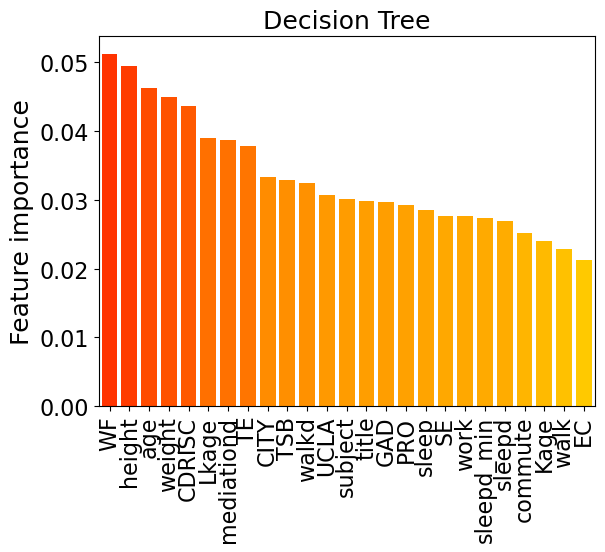

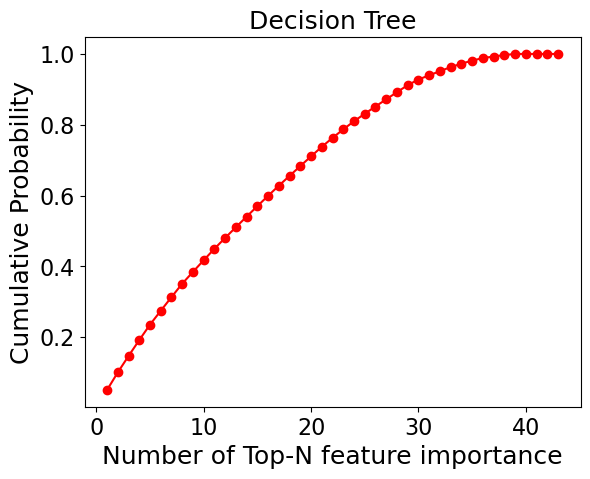

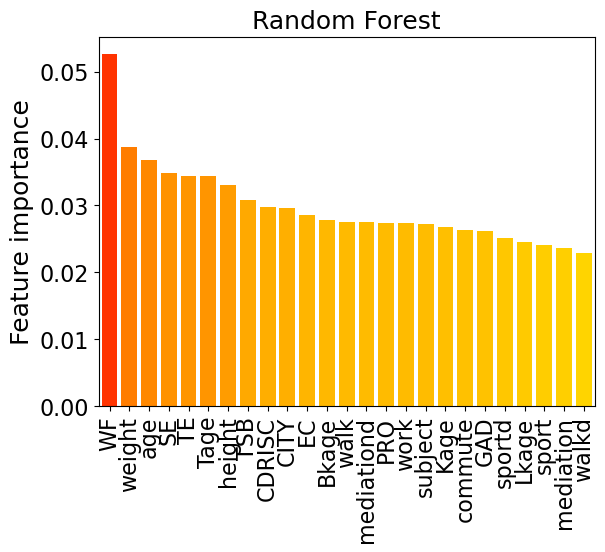

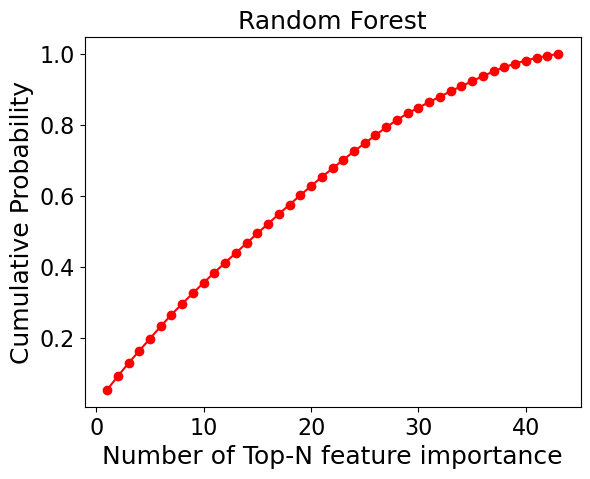

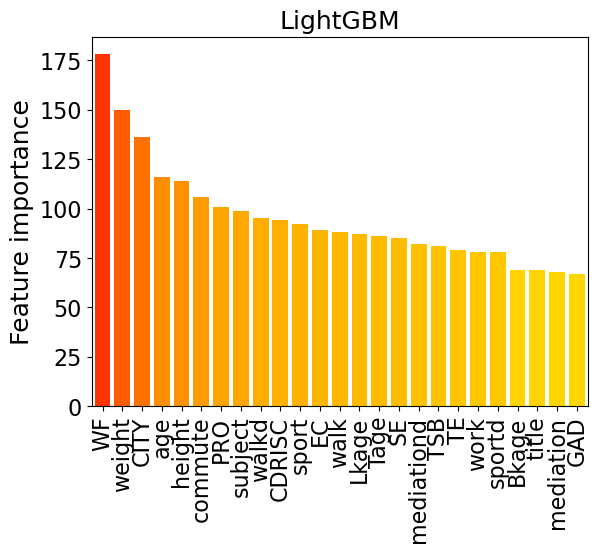

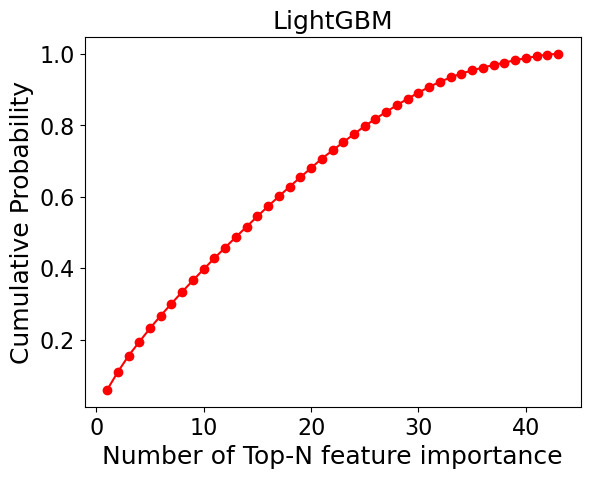

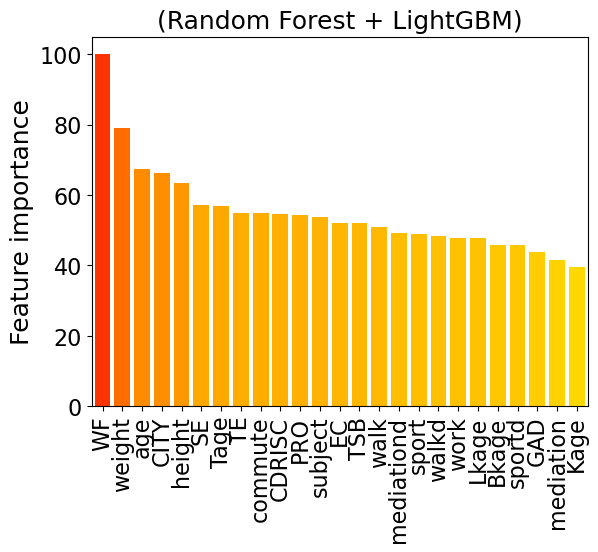

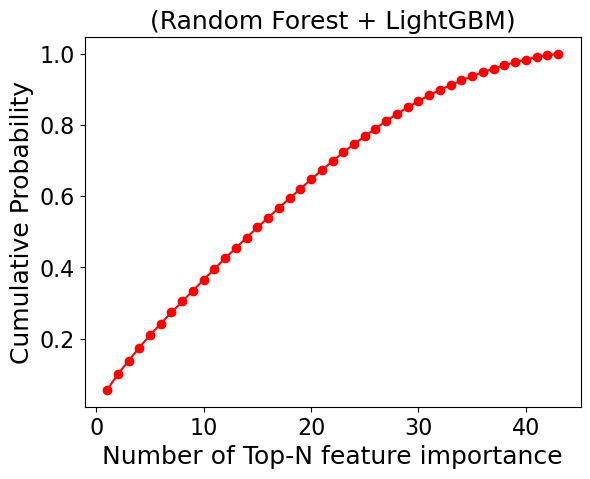

In [2]:
def plot_topN_feature_importance(columns, feature_importance, title):
    columns, feature_importance = sort_feature(columns, feature_importance)
    plt.figure()

    x = columns
    y = feature_importance

    xsum=[]; ysum=[]
    for i in range(len(y)):
        sum=0
        for j in range(i+1):
            sum=sum+y[j]
        xsum.append(i+1)
        ysum.append(sum)
        
    ysum=ysum/max(ysum)
    
    plt.scatter(xsum, ysum, c='red')
    plt.plot(xsum, ysum, c='red')
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.title(title, fontsize=18)
    plt.xlabel("Number of Top-N feature importance", fontsize=18)
    plt.ylabel("Cumulative Probability", fontsize=18)

    # 跑出来的结果图片保存的位置
    plt.savefig('./%s_topNimportance.jpg' %(title), dpi=400)

def plot_feature_importance(columns, feature_importance, title):
    
    columns, feature_importance = sort_feature(columns, feature_importance)
    plt.figure()
    # plt.grid()
    # plt.xlabel("feature_importance")

    x = columns
    y = feature_importance

    norm = plt.Normalize(min(y), max(y))
    norm_y = 1.2 - norm(y)
        
    map_vir = cm.get_cmap(name='autumn')
    colormp = map_vir(norm_y)

    plt.yticks(fontsize=16)
    plt.ylabel("Feature importance", fontsize=18)  
    
    plt.xticks(rotation=90, fontsize=16)    
    plt.xlim([-0.55, 24.55])
    # plt.xlabel("Feature importance", fontsize=18)
        
    plt.bar(columns, feature_importance, color=colormp) # color=['green']
    plt.title(title, fontsize=18)
    # 跑出来的结果图片保存的位置
    plt.savefig('./%s_importance.jpg' %(title), dpi=400)

rfvals = []
litgbm = []
ave_rfgbm = []

for model_name, vals in result_map[0].items():
    print("{}训练集准确率：{}， 测试集准确率：{}".format(model_name, vals[0], vals[1]))
    if isinstance(vals[2], np.ndarray):
        plot_feature_importance(df_src_columns, vals[2], model_name)
        plot_topN_feature_importance(df_src_columns, vals[2], model_name)
        
        if model_name == 'Random Forest':
            rfvals_max = max(vals[2])
            for i in range(len(df_src_columns)):
                rfvals.append(vals[2][i] / rfvals_max * 100)
            
        if model_name == 'LightGBM':
            litgbm_max = max(vals[2])
            for i in range(len(df_src_columns)):
                litgbm.append(vals[2][i] / litgbm_max * 100)

for i in range(len(df_src_columns)):
    ave_rfgbm.append((rfvals[i] + litgbm[i]) / 2.0)
    
plot_feature_importance(df_src_columns, ave_rfgbm, '(Random Forest + LightGBM)')
plot_topN_feature_importance(df_src_columns, ave_rfgbm, '(Random Forest + LightGBM)')

    # plot_auc(vals[-2], vals[-1], model_name)

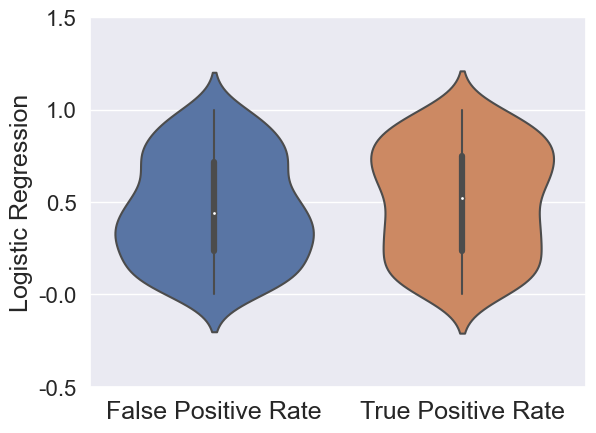

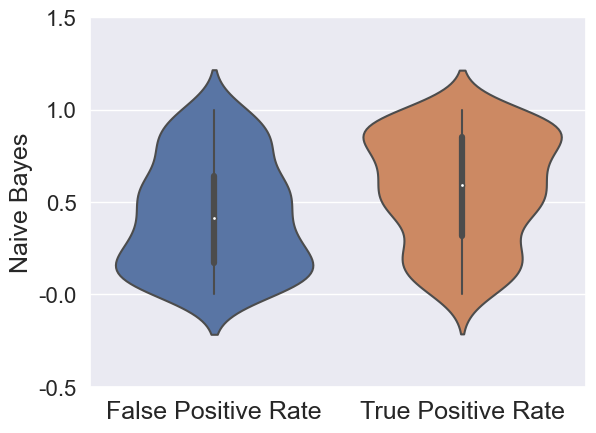

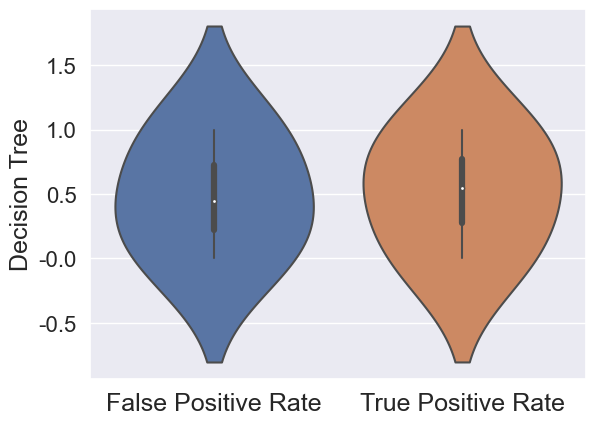

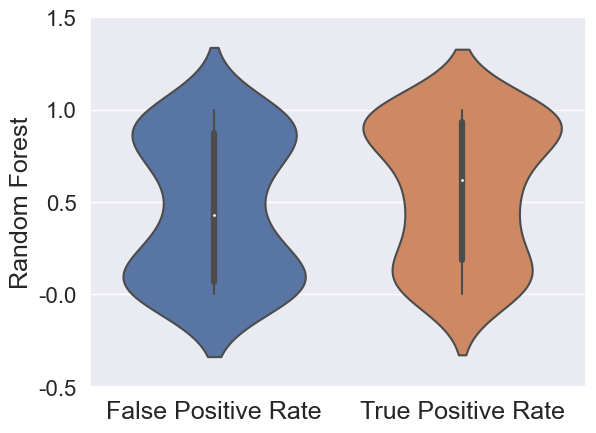

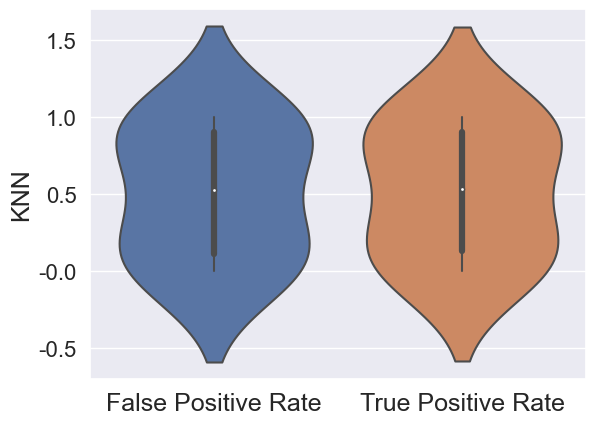

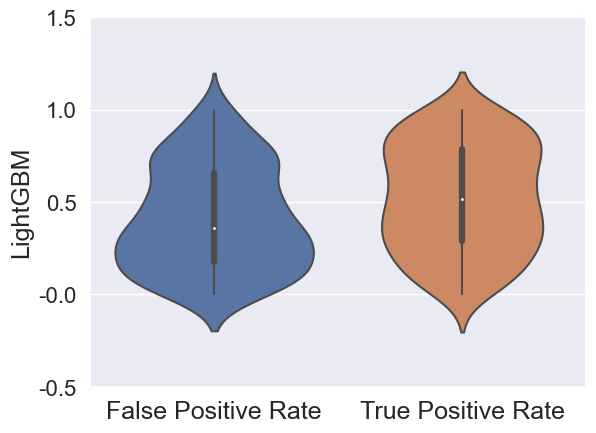

<Figure size 640x480 with 0 Axes>

In [3]:
import seaborn as sns
def plot_violinplot(x_vals2, x_vals1, model_name): 
    
    tips=[x_vals2, x_vals1]
    
    sns.set_theme(style="darkgrid")
    ax = sns.violinplot(data=tips)

    ax.set_ylabel("%s" %(model_name), fontsize=18)
    ax.set_xticks([0, 1],['False Positive Rate', 'True Positive Rate'], fontsize=18)
    ax.set_yticks([-0.5, 0.0, 0.5, 1.0, 1.5],['-0.5', '-0.0', '0.5', '1.0', '1.5'], fontsize=16)

    plt.figure()
    figure = ax.get_figure()
    figure.savefig('./%s_violinplot.jpg' %(model_name), dpi=400)

i=0
for model_name, vals in result_map[0].items():
    i += 1
    # colors_list = ['#78C850', '#F08030',  '#6890F0',  '#A8B820',  '#F8D030', '#E0C068', '#C03028', '#F85888', '#98D8D8']
    # color = colors_list[i]
    # print(vals[4])
    fpr, tpr, thersholds = roc_curve(vals[-2], vals[-1])
    plot_violinplot(fpr, tpr, model_name) 

[0.53479629 0.40053637 0.53218354 0.47219576 0.50052701 0.47829857
 0.46860787 0.60649656 0.55933073 0.51509366 0.48288125 0.54663946
 0.50555038 0.52805416 0.44245095 0.51106695 0.42157843 0.58100879
 0.48340274 0.35902227 0.53720072 0.57311183 0.47448233 0.52865663
 0.42299012 0.52407365 0.55434582 0.5156733  0.52150914 0.55965134
 0.50534949 0.45706124 0.46182715 0.48571003 0.5135457  0.5224992
 0.56032343 0.47649274 0.52373216 0.53557119 0.55821715 0.54972121
 0.53351728 0.58414159 0.52168023 0.61636448 0.52119038 0.48031587
 0.49946353 0.49622891 0.53584756 0.45107678 0.51332414 0.54709061
 0.52940475 0.55764152 0.41538172 0.54308473 0.45989319 0.53654461
 0.46067478 0.53753685 0.49892558 0.53618346 0.51535048 0.49457731
 0.43482115 0.53268589 0.55911739 0.55480473 0.43162828 0.50019067
 0.62600104 0.49111167 0.54234017 0.41770333 0.48068729 0.49997234
 0.47138772 0.51180304 0.54045967 0.4957287  0.47347503 0.49691
 0.4276449  0.54399746 0.50407199 0.48297347 0.46474812 0.53226922

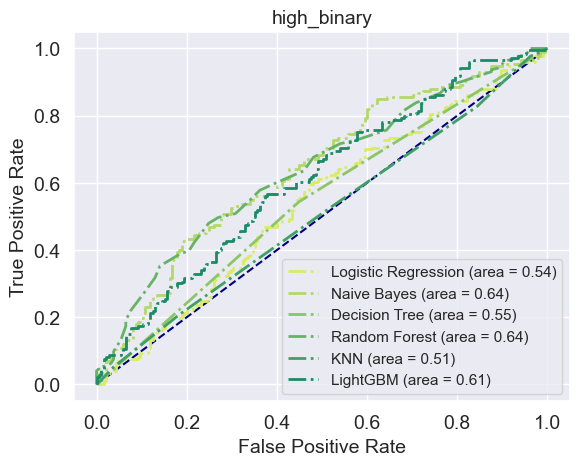

In [4]:
def plot_auc(y_label, y_pre, model_name):
    fpr, tpr, thersholds = roc_curve(y_label, y_pre)
    plt.figure()
    for i, value in enumerate(thersholds):
        print("%f %f %f" % (fpr[i], tpr[i], value))

    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'k--', label=' (area = {0:.2f})'.format(roc_auc), lw=2)
    
    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('%s'%(model_name))
    plt.legend(loc="lower right")
    plt.savefig('./auc.jpg', dpi=1000)
    plt.show()

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xticks(fontsize=14)
plt.xlim([-0.05, 1.05])# 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.yticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)  # 可以使用中文，但需要导入一些库即字体
plt.title('high_binary', fontsize=14)
i=0

for model_name, vals in result_map[0].items():
    i += 1
    color = cm.summer(1-i*0.15)
    print(vals[-1])
        
    fpr, tpr, thersholds = roc_curve(vals[-2], vals[-1])
    print(model_name, len(thersholds))

    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.plot(fpr, tpr, '-.', label= model_name +' (area = {0:.2f})'.format(roc_auc), color=color, lw=2)

plt.legend(loc="lower right")
plt.savefig('./auc.jpg', dpi=1000)
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 计算模型组合后的得分
def calc_combined_model_scores(lgbm_preds_proba, rf_preds_proba, y_test):
    # 组合模型：取两个模型的平均预测概率
    combined_proba = (lgbm_preds_proba + rf_preds_proba) / 2
    
    # 计算各项得分
    combined_preds = (combined_proba >= 0.5).astype(int)  # 二分类阈值为0.5
    accuracy = accuracy_score(y_test, combined_preds)
    auc_score = roc_auc_score(y_test, combined_proba)
    precision = precision_score(y_test, combined_preds)
    recall = recall_score(y_test, combined_preds)
    f1score = f1_score(y_test, combined_preds)
    
    return accuracy, auc_score, precision, recall, f1score

# 使用之前的result_map来提取LightGBM和Random Forest的预测结果
lightgbm_proba = result_map[0]['LightGBM'][-1]
randomforest_proba = result_map[0]['Random Forest'][-1]
y_test = result_map[0]['LightGBM'][-2]

# 计算组合模型的得分
combined_accuracy, combined_auc, combined_precision, combined_recall, combined_f1 = calc_combined_model_scores(lightgbm_proba, randomforest_proba, y_test)

# 输出组合模型的得分
print("LightGBM + Random Forest 组合模型的得分:")
print(f"训练集准确率: {result_map[0]['LightGBM'][0]:.5f} (使用LightGBM的训练集准确率作为代表)")
print(f"测试集准确率: {combined_accuracy:.5f}")
print(f"测试集AUC分数: {combined_auc:.5f}")
print(f"测试集Precision: {combined_precision:.5f}")
print(f"测试集Recall: {combined_recall:.5f}")
print(f"测试集F1 Score: {combined_f1:.5f}")


LightGBM + Random Forest 组合模型的得分:
训练集准确率: 1.00000 (使用LightGBM的训练集准确率作为代表)
测试集准确率: 0.58380
测试集AUC分数: 0.62315
测试集Precision: 0.56250
测试集Recall: 0.62428
测试集F1 Score: 0.59178
